### MANDATORY ASSIGNMENT 2

In [5]:
from sklearn import datasets

In [6]:
import numpy as np

In [7]:
iris = datasets.load_iris()

In [8]:
X = iris.data
Y = iris.target

#### Task 1) data exploration

In [9]:
len(X)

150

In [10]:
print(X.shape, Y.shape)

(150, 4) (150,)


In [11]:
print(np.min(X), np.max(X))
print(np.min(Y), np.max(Y))

0.1 7.9
0 2


In [12]:
from sklearn.preprocessing import MinMaxScaler
from qiskit import QuantumCircuit, transpile, assemble
from qiskit_aer import Aer, AerSimulator
from qiskit.visualization import plot_histogram
from qiskit.circuit import Parameter
from qiskit_algorithms.optimizers import SPSA
import matplotlib.pyplot as plt
from qiskit.result import marginal_counts
from sklearn.metrics import log_loss # loss function
from sklearn.metrics import accuracy_score # accuracy
import time
import pickle
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import concurrent.futures

In [13]:
scaler = MinMaxScaler(feature_range=(0, np.pi)) # since we are using angle encoding, we need to scale from 0 to pi
X = scaler.fit_transform(X)

In [ ]:
class QuantumMachineLearning:
    def __init__(self, X_train, y_train, X_val, y_val, num_qubits = 4, num_layers = 3, circuit = 'real_amplitudes', epsilon = 0.2, learning_rate = 0.1):
        self.X_train = X_train
        self.y_train = y_train
        self.X_val = X_val
        self.y_val = y_val
        self.num_qubits = num_qubits
        self.circuit = circuit
        self.num_layers = num_layers
        self.num_classes = len(set(y_train))
        self.rng = np.random.default_rng(42)
        self.number_of_parameters = self.num_qubits * self.num_layers if circuit == 'real_amplitudes' else self.num_layers * self.num_qubits + (self.num_qubits // 2) + (self.num_qubits // 2)
        self.initial_parameters = self.rng.uniform(0, np.pi, self.number_of_parameters)
        self.epsilon = epsilon
        self.learning_rate = learning_rate
        self.base_circuit = self._create_base_circuit()
        self.backend = AerSimulator(method = 'statevector')
      

    
    def angle_encoding(self, qc, data_point):
        [qc.rx(data_point[qubit], qubit) for qubit in range(self.num_qubits)]
        return qc

    def real_amplitudes(self, qc, parameters):
        param_indices = np.arange(len(parameters)).reshape(self.num_layers, self.num_qubits)
        
        for layer in range(self.num_layers):
            [qc.ry(parameters[param_indices[layer, qubit]], qubit) 
             for qubit in range(self.num_qubits)]
            qc.barrier()
            
            [qc.cx(qubit, qubit+1) for qubit in range(self.num_qubits-1)]
            qc.barrier()

        qc.measure_all()
        return qc
    


    def QCNN(self, qc, parameters):
            
        if self.num_qubits % 2 != 0:
            raise ValueError("The number of qubits must be even.")
        
        param_indices = np.arange(self.num_layers * self.num_qubits).reshape(self.num_layers, self.num_qubits)

        for layer in range(self.num_layers):
            [qc.cx(qubit, qubit + 1) for qubit in range(0, self.num_qubits - 1, 2)]
            [qc.ry(parameters[param_indices[layer][qubit]], qubit) for qubit in range(self.num_qubits)]

            [qc.cx(qubit, qubit + 1) for qubit in range(0, self.num_qubits - 1, 2)]
            qc.barrier()

        qc.barrier()
        
        # Measure every alternate qubit starting from qubit 1
        [qc.measure(qubit, qubit) for qubit in range(1, self.num_qubits, 2)]

        start_crz = self.num_layers * self.num_qubits
        [qc.crz(parameters[start_crz + qubit // 2], qubit + 1, qubit) for qubit in range(0, self.num_qubits - 1, 2)]

        qc.barrier()

        if self.num_qubits >= 4:
            qc.cx(0, self.num_qubits // 2)
        
        start_final_ry = start_crz + self.num_qubits // 2
        [qc.ry(parameters[start_final_ry + qubit // 2], qubit) for qubit in range(0, self.num_qubits, 2)]

        if self.num_qubits >= 4:
            qc.cx(0, self.num_qubits // 2)

        # Final measurement of selected qubits (first and middle qubits)
        qc.measure(0, 0)
        qc.measure(self.num_qubits // 2, self.num_qubits // 2)

        return qc

        

    def _create_base_circuit(self):      
        if self.circuit == 'real_amplitudes':
            filename = 'real_amplitudes_circuit.png'
            qc = QuantumCircuit(self.num_qubits)
            qc = self.angle_encoding(qc, np.array([Parameter(f"theta_{i}") for i in range(self.num_qubits)]))
            qc = self.real_amplitudes(qc ,np.array([Parameter(f"phi_{i}{j}")
                                                     for i in range(self.num_qubits)
                                                     for j in range(self.num_layers)]))
        
        elif self.circuit.upper() == 'QCNN':
            filename = 'QCNN_circuit.png'
            qc = QuantumCircuit(self.num_qubits, self.num_qubits)
            qc = self.angle_encoding(qc, np.array([Parameter(f"theta_{i}") for i in range(4)]))
            parameters = np.array([Parameter(f"phi_{i}") for i in range(self.number_of_parameters)])
            qc = self.QCNN(qc, parameters)
        
        circuit_drawing = qc.draw(output='mpl', style={'backgroundcolor': '#FFFFFF'})
        circuit_drawing.savefig(filename, dpi=300, bbox_inches='tight')
        plt.close() 
        return qc


    def prepare_circuit(self, data_point, params):
        qc = self.base_circuit.copy()
        qc.assign_parameters(np.concatenate([data_point, params]), inplace = True)
        
        return qc
   
    def run_circuit(self, data_point, params, shots = 100):
        qc = self.prepare_circuit(data_point, params)     

        tqc = transpile(qc, self.backend)

        job = self.backend.run(tqc, shots=shots)
        result = job.result()
        counts = result.get_counts(qc)

        if self.circuit.upper() == 'QCNN':
            counts = marginal_counts(counts, [0, 2])
        

        return counts

    
    def data_decoding(self, output):
        return int(output, 2) % self.num_classes
    
    def loss_function(self, updated_params, val = False, shots = 100):
        X = self.X_train if not val else self.X_val
        y = self.y_train if not val else self.y_val

        def process_counts(x):
            counts = self.run_circuit(x, updated_params, shots = shots)

            count_classes = {x : 0 for x in range(self.num_classes)}
            [count_classes.update({self.data_decoding(output): 
                                 count_classes.get(self.data_decoding(output), 0) + count/shots}) 
             for output, count in counts.items()]
        
            return [count_classes[x] for x in range(self.num_classes)]        
         

        predicted_probabilities = np.array([process_counts(x) for x in X])

        logloss = log_loss(y, predicted_probabilities)

        #print(f"Parameters: {updated_params} loss: {logloss}")
        return logloss

    def SPSA_optimize(self, maxiter = 50):
        optimizer = SPSA(maxiter=maxiter)
        # Optimize the parameters
        optimized = optimizer.minimize(fun=self.loss_function, x0=self.initial_parameters)

        print("Optimized Parameters:", optimized.x)
        print("Minimum Loss:", optimized.fun)
        self.optimized_params = optimized.x
        self.min_loss = optimized.fun
    

    def gradient(self, params):
        size = len(params)
        plus = np.broadcast_to(params, (size, size)) + np.eye(size) * self.epsilon
        minus = np.broadcast_to(params, (size, size)) - np.eye(size) * self.epsilon
        L_plus = np.array([self.loss_function(p) for p in plus])
        L_minus = np.array([self.loss_function(p) for p in minus])

        return (L_plus - L_minus) / (2 * self.epsilon)
    
    
    def run_gradient_descent(self, maxiter = 50, shots = 100):
        self.all_epochs = np.empty((0, 3))
        current_point = self.initial_parameters
        parameter_storage = np.empty((0, len(current_point)))
        early_stopping = False
        for epoch in range(maxiter):
            start = time.time()

            gradients = self.gradient(current_point)
            current_point = [current_point[j] - self.learning_rate * gradients[j] for j in range(len(gradients))]

            training_loss  = self.loss_function(current_point, shots= shots)
            validation_loss = self.loss_function(current_point, val = True, shots= shots)
            parameter_storage = np.vstack([parameter_storage, current_point])

            end = time.time()
            elapsed_time = end - start
            self.all_epochs = np.vstack([self.all_epochs, [training_loss, validation_loss, elapsed_time]])

            if epoch >= 10:
                val_losses = self.all_epochs[:,1]
                if np.mean(val_losses[-5:]) > np.mean(val_losses[-10:]): # if last 5 validation losses are greater than last 10, break
                    best_index = np.argmin(val_losses)
                    current_point = parameter_storage[best_index]
                    print(f"""Early Stopping at epoch {epoch}, 
                        Training Loss: {self.all_epochs[:,0][best_index]}, 
                        Validation Loss: {val_losses[best_index]},""")
                    early_stopping = True
                    break

            print(f"Epoch {epoch} Training Loss: {training_loss}, Validation Loss: {validation_loss}, Time: {elapsed_time}")
       
        current_point = [float(p) for p in current_point]
        loss = training_loss if not early_stopping else self.all_epochs[:,0][best_index]
        print("Optimized Parameters:", current_point, "Loss:", loss)
        self.optimized_params = current_point  
        self.min_loss = loss
    
    def predict(self, data_point): #paramteres must be optimized before prediction
        prediction_shots = 100000 # more shots as the circuit is only run once
        counts = self.run_circuit(data_point, self.optimized_params, shots = prediction_shots)

        predicted_probabilites = {x : 0 for x in range(self.num_classes)}
            
        # Decode each measurement outcome and aggregate probabilites for each class
        for output, count in counts.items():
            class_num = self.data_decoding(output)
            predicted_probabilites[class_num] += count / prediction_shots
        
        
        # Determine the predicted class by choosing the class with the highest probability
        predicted_class = max(predicted_probabilites, key=predicted_probabilites.get)
        
        return predicted_class

    def predict_dataset(self, X):
        return [self.predict(data_point) for data_point in X]
    
    def performance(self, y_test, X_test):
        predictions = self.predict_dataset(X_test)
        self.accuracy = accuracy_score(y_test, predictions)
        print('Accuracy score:', self.accuracy)

        #generate and display the confusion matrix
        cm = confusion_matrix(y_test, predictions)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap="Blues")
        plt.show()
        
        return self.accuracy

    def save(self):
        with open('model_data.pkl', 'wb') as f:
            pickle.dump({
                'optimized_params': self.optimized_params,
                'min_loss': self.min_loss,
                'accuracy': self.accuracy,
                'all_epochs': self.all_epochs
            }, f)

    def plot_training_validation_loss(self, train_loss, val_loss, steps=None):
        if steps is None:
            steps = range(len(train_loss))
        
        plt.figure(figsize=(10, 6))
        #
        plt.plot(steps, train_loss, label='Training loss', color='#1f77b4')  # Blue line
        plt.plot(steps, val_loss, label='Validation loss', color='#ff7f0e')  # Orange line
        
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training Loss vs Validation Loss')
        plt.legend()
        plt.grid(False)

        plt.tight_layout()
        
        plt.show()
    
    
    

In [165]:
from sklearn.model_selection import train_test_split

In [180]:
X_train, X_temp, y_train, y_temp = train_test_split(X, Y, test_size=0.3, random_state=42) # 70% training 
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp) # 15% validation, 15% testing

In [183]:
np.unique(y_val, return_counts=True)

(array([0, 1, 2]), array([9, 6, 7]))

In [184]:
import itertools

In [185]:
def hyperparameter_tuning(num_layers, epsilon, learning_rate):
    val_accuracy = 0
    for epsilon, learning_rate, num_layers in itertools.product(epsilon, learning_rate, num_layers):
        model = QuantumMachineLearning(X_train, y_train, X_val, y_val, num_layers = num_layers, circuit ='QCNN', epsilon = epsilon, learning_rate = learning_rate)
        model.run_gradient_descent()
        accuracy = model.performance(y_val, X_val)
        if accuracy > val_accuracy:
            val_accuracy = accuracy
            best_model = model
            best_params = [num_layers, epsilon, learning_rate]
    print(f"Best Parameters: {best_params}, Validation Accuracy: {val_accuracy}")
    return best_model
    

Epoch 0 Training Loss: 1.1247055881998884, Validation Loss: 0.9352632330790456, Time: 53.41381216049194
Epoch 1 Training Loss: 1.0149965083982417, Validation Loss: 0.8674838883194571, Time: 56.04355597496033
Epoch 2 Training Loss: 0.9310083786090402, Validation Loss: 0.7595270629635746, Time: 57.57700824737549
Epoch 3 Training Loss: 0.9010694299095203, Validation Loss: 0.696982135130312, Time: 57.8223512172699
Epoch 4 Training Loss: 0.854982345149427, Validation Loss: 0.6437728357899436, Time: 58.268450021743774
Epoch 5 Training Loss: 0.8258509184273843, Validation Loss: 0.6564012533850083, Time: 58.3672137260437
Epoch 6 Training Loss: 0.8013861720890322, Validation Loss: 0.5930366290501629, Time: 58.641802072525024
Epoch 7 Training Loss: 0.7884756882024092, Validation Loss: 0.6359536189762172, Time: 59.43337297439575
Epoch 8 Training Loss: 0.7523756227557831, Validation Loss: 0.5725084808248285, Time: 59.19121694564819
Epoch 9 Training Loss: 0.778648013507115, Validation Loss: 0.57766

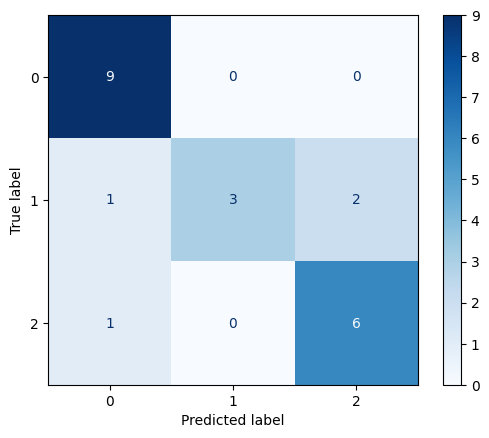

Best Parameters: [2, 0.2, 0.5], Validation Accuracy: 0.8181818181818182


In [191]:
epsilon_values = [0.2]
learning_rate_values = [0.5]
num_layers_values = [2]
best_model = hyperparameter_tuning(num_layers_values, epsilon_values, learning_rate_values)

Accuracy score: 0.8695652173913043


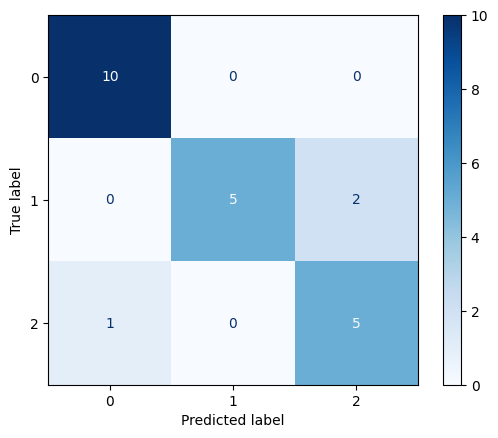

0.8695652173913043

In [195]:
best_model.performance(y_test, X_test)

In [196]:
best_model.save()

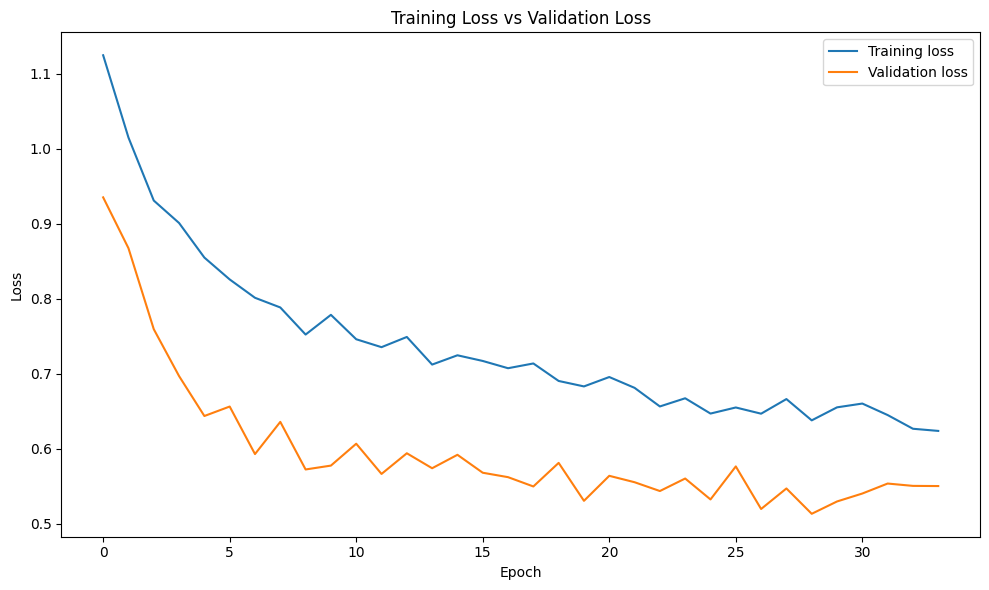

In [197]:
best_model.plot_training_validation_loss(best_model.all_epochs[:,0], best_model.all_epochs[:,1])